In [1]:
import torch


In [2]:
print("woohoo")

woohoo


In [4]:
################################################################################
#
# This code was taken from 
# v2, 28/11/2018
# https://github.com/choosehappy/PytorchDigitalPathology/blob/master/segmentation_epistroma_unet/train_unet.ipynb
#
# This calls the UNet library. We make a local copy of the code, which was
# developed at Univ. Feriburg, and the code was copied from 
# https://github.com/jvanvugt/pytorch-unet
#
################################################################################
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

from unet import UNet

import PIL
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob

from tensorboardX import SummaryWriter

import scipy.ndimage 

import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix

#################################
# <> ACK! Hardcoded tissue type
dataname = "epistroma"
#dataname = "nuclei"

# <> ACK! Hardcoded path! Replace this!
cur = os.getcwd()
print(cur)
os.chdir('./epi')
print('Current working directory: ' + os.getcwd())
#################################

#####################
# Unet has the possibility of masking out pixels in the output image, we can specify the index value here (though not used)
ignore_index = -100 
gpuid=0

#####################
# Unet params
# these parameters get fed directly into the UNET class, and more description of them can be discovered there
n_classes = 2  #number of classes in the data mask that we'll aim to predict
in_channels = 3  #input channel of the data, RGB = 3
padding= True  #should levels be padded
depth= 5  #depth of the network 
wf= 2  #wf (int): number of filters in the first layer is 2**wf, was 6
up_mode= 'upconv' #should we simply upsample the mask, or should we try and learn an interpolation 
batch_norm = True #should we use batch normalization between the layers

#######################
### training params
batch_size=3
patch_size=256
num_epochs = 100
### Edges tend to be the most poorly segmented given how little area they occupy in the training set, 
### this paramter boosts their values along the lines of the original UNET paper
edge_weight = 1.1 
### How many phases did we create databases for?
phases = ["train","val"] 
### When should we do valiation? note that validation is time consuming, so as opposed to doing 
### for both training and validation, we do it only for vlaidation at the end of the epoch
validation_phases= ["val"] 
##
### Specify if we should use a GPU (cuda) or only the CPU
### The Totch device is where we allocate and manipulate a tensor. This is either
### the local CPU or a GPU.
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
#torchDevice = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')
torchDevice = torch.device('cpu')
##
### Build the UNetRuntime according to the paramters specified above and copy it to the GPU. 
UNetRuntime = UNet(n_classes=n_classes, in_channels=in_channels, padding=padding, depth=depth, wf=wf, up_mode=up_mode, batch_norm=batch_norm).to(torchDevice)
### Print out the number of trainable parameters
##print(f"total params: \t{sum([np.prod(p.size()) for p in UNetRuntime.parameters()])}")
##
##
##################################################################################
### helper function for pretty printing of current time and remaining time
##################################################################################
##
##########################################
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
##
##########################################
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
##
##
##
################################################################################
# This defines our dataset class which will be used by the dataloader
# This encapsulates applying transformations to a single raw image to make several
# derived images.
################################################################################
class Dataset(object):
    #######################################
    #######################################
    def __init__(self, fname, img_transform=None, mask_transform = None, edge_weight = False):
        # Save the constructor parameters for later use
        self.fname = fname
        self.edge_weight = edge_weight
        
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        
        self.tables = tables.open_file(self.fname)
        self.numpixels = self.tables.root.numpixels[:]
        self.nitems = self.tables.root.img.shape[0]
        self.tables.close()
        
        self.img = None
        self.mask = None
    # End: __init__()
        
    #######################################
    #######################################
    def __getitem__(self, index):
        #print("Debug> Inside getitem. index = " + str(index))

        # Open the database and read the nth image and mask.
        # opening should be done in __init__ but seems to be
        # an issue with multithreading so doing here
        with tables.open_file(self.fname, 'r') as db:
            self.img = db.root.img
            self.mask = db.root.mask
       
            #get the requested image and mask from the pytable
            img = self.img[index,:,:,:]
            mask = self.mask[index,:,:]
        
        # the original Unet paper assignes increased weights to the edges of the annotated objects
        # their method is more sophistocated, but this one is faster, we simply dilate the mask and 
        # highlight all the pixels which were "added"
        if (self.edge_weight):
            weight = scipy.ndimage.morphology.binary_dilation(mask==1, iterations =2) & ~mask
        else: #otherwise the edge weight is all ones and thus has no affect
            weight = np.ones(mask.shape,dtype=mask.dtype)
        
        # To use the transformations given by torchvision, inputs need to be 3D, 
        # so here we convert from 1d to 3d by repetition
        mask = mask[:,:,None].repeat(3, axis=2) 
        weight = weight[:,:,None].repeat(3,axis=2) 
        
        # Save the image and mask and weight we extracted above.
        # This is the result if we do not do any transformatinos below.
        img_new = img
        mask_new = mask
        weight_new = weight

        # We may do a transformatino to the image. This lets us use a single image many
        # times, each with a different transformation like rotate, or zoom, or something else.
        # This lets us train a net with a relatively small number of images.

        # Get a random seed so that we can reproducibly do the transofrmations
        seed = random.randrange(sys.maxsize) 
        
        if self.img_transform is not None:
            random.seed(seed) # apply this seed to img transforms
            img_new = self.img_transform(img)

        if self.mask_transform is not None:
            random.seed(seed)
            mask_new = self.mask_transform(mask)
            mask_new = np.asarray(mask_new)[:,:,0].squeeze()
           
            random.seed(seed)
            weight_new = self.mask_transform(weight)
            weight_new = np.asarray(weight_new)[:,:,0].squeeze()

        # Return the data
        return img_new, mask_new, weight_new
    # End: __getitem__()


    def __len__(self):
        return self.nitems
    # End: __len__()



##################################################################################
### These are the transformations we can use to make a single image look like
### several different images.
###
### note that since we need the transofrmations to be reproducible for both masks and images
### we do the spatial transformations first, and afterwards do any color augmentations
##################################################################################
img_transform = transforms.Compose([
     transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    transforms.RandomResizedCrop(size=patch_size),
    transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=.5),
    transforms.RandomGrayscale(),
    transforms.ToTensor()
    ])
##
##
mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    transforms.RandomResizedCrop(size=patch_size,interpolation=PIL.Image.NEAREST),
    transforms.RandomRotation(180),
    ])
##
##
##
##
##
##
##################################################################################
### Training Code
##################################################################################
dataset = {}
dataLoader = {}
### Create a dataloader for each phase, 
for phase in phases: 
    dbFilePathname = "./"+dataname+"_"+phase+".pytable";
    print('dbFilePathname: ' + dbFilePathname)
    dataset[phase] = Dataset(dbFilePathname, img_transform = img_transform, mask_transform = mask_transform, edge_weight = edge_weight)
    dataLoader[phase] = DataLoader(dataset[phase], batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
##
##
#######################
### Visualize a single example to verify that it is correct
##(img,patch_mask,patch_mask_weight)=dataset["train"][7]
### Draw the plain image. Do not try to draw the mask; it has been converted to 0 and 1 bytes,
### which will both look like just black pixels.
###>plt.imshow(img)
###>plt.show()
##
###>fig, ax = plt.subplots(1, 4, figsize=(10, 4))  # 1 row, 2 columns
### Build output showing original patch  (after augmentation), class = 1 mask, weighting mask, overall mask (to see any ignored classes)
###>ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
###>ax[1].imshow(patch_mask==1)
###>ax[2].imshow(patch_mask_weight)
###>ax[3].imshow(patch_mask)
###>plt.show()
##
##
#######################
### Create an optimizer.
### This uses the "Adam" algorithm, which is documented in 
###      Diederik P. Kingma, Jimmy Ba, 
###      "Adam: A Method for Stochastic Optimization", https://arxiv.org/abs/1412.6980
### There are several other possible algorithms, including stochastic gradient descent and more.
### The source said, "adam is going to be the most robust, though perhaps not the best performing". Not sure about this.
optim = torch.optim.Adam(UNetRuntime.parameters())
##
##
#######################
### The classes are the types of pixels, like nucleus vs cytoplasm.
### We can weight individual classes, which we do based on their presense in the trainingset
### to avoid biasing any particular class
nclasses = dataset["train"].numpixels.shape[1]
class_weight = dataset["train"].numpixels[1,0:2] #don't take ignored class into account here
class_weight = torch.from_numpy(1 - class_weight/class_weight.sum()).type('torch.FloatTensor').to(torchDevice)
##
### show final used weights, make sure that they're reasonable before continouing
###print(class_weight) 
##
### reduction = 'none' makes sure we get a 2D output instead of a 1D "summary" value
##criterion = nn.CrossEntropyLoss(weight = class_weight, ignore_index = ignore_index, reduction = 'none') 
##
### The tensorboard visualiser
##writer = SummaryWriter() 
##best_loss_on_test = np.Infinity
##edge_weight = torch.tensor(edge_weight).to(torchDevice)
##start_time = time.time()
##
### Iterate for a fixed number of Epochs; each iteration refines the model.
### The number of iterations is a tuned constant, defined above.
##for epoch in range(num_epochs):
##    # Initialize the per-epoch performance variables 
##    all_acc = {key: 0 for key in phases} 
##    all_loss = {key: torch.zeros(0).to(torchDevice) for key in phases}
##    cmatrix = {key: np.zeros((2,2)) for key in phases}
##
##    # Iterate through both training and validation phases
##    for phase in phases: 
##        # Set UNetRuntime to the current mode
##        # When in eval mode, we don't want parameters to be updated
##        if phase == 'train':
##            UNetRuntime.train()
##        else: 
##            UNetRuntime.eval()
##
##        # Each iteration will process one image with an associated mask
##        # dataLoader returns (img_new, mask_new, weight_new)
##        # These 3 are all torch.Tensor objects, which is an array wrapped in a class
##        for imageNumber, (currentImageTensor, y, y_weight) in enumerate(dataLoader[phase]): 
##            print("imageNumber: " + str(imageNumber))
##            # Copy the image and mask to the processor where it will be manipulated. 
##            # This is a PyTorch action, and allows you to move runtime data structures to a GPU 
##            # for faster computation.
##            currentImageTensor = currentImageTensor.to(torchDevice)  # [Nbatch, 3, H, W]
##            y_weight = y_weight.type('torch.FloatTensor').to(torchDevice)
##            y = y.type('torch.LongTensor').to(torchDevice)  # [Nbatch, H, W] with class indices (0, 1)
##
##            # dynamically set gradient computation, in case of validation, this isn't needed
##            # disabling is good practice and improves inference time
##            with torch.set_grad_enabled(phase == 'train'):
##                #>print(str(currentImageTensor))
##                prediction = UNetRuntime.forward(currentImageTensor)  # [N, Nclass, H, W]
##                loss_matrix = criterion(prediction, y)
##                loss = (loss_matrix * (edge_weight**y_weight)).mean() #can skip if edge weight==1
##
##                # In train mode, we do back propogation
##                if (phase=="train"): 
##                    optim.zero_grad()
##                    loss.backward()
##                    optim.step()
##                    train_loss = loss
##
##                all_loss[phase] = torch.cat((all_loss[phase],loss.detach().view(1,-1)))
##
##                # if this phase is part of validation, compute confusion matrix
##                if phase in validation_phases: 
##                    p = prediction[:,:,:,:].detach().cpu().numpy()
##                    cpredflat = np.argmax(p,axis=1).flatten()
##                    yflat = y.cpu().numpy().flatten()
##
##                    cmatrix[phase] = cmatrix[phase] + confusion_matrix(yflat, cpredflat, labels = range(n_classes))
##            # End: with torch.set_grad_enabled(phase == 'train'):
##        # End: for imageNumber, (currentImageTensor, y, y_weight) in enumerate(dataLoader[phase]):
##
##        all_acc[phase] = (cmatrix[phase] / cmatrix[phase].sum()).trace()
##        all_loss[phase] = all_loss[phase].cpu().numpy().mean()
##
##        #save metrics to tensorboard
##        writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
##        if phase in validation_phases:
##            writer.add_scalar(f'{phase}/acc', all_acc[phase], epoch)
##            writer.add_scalar(f'{phase}/TN', cmatrix[phase][0,0], epoch)
##            writer.add_scalar(f'{phase}/TP', cmatrix[phase][1,1], epoch)
##            writer.add_scalar(f'{phase}/FP', cmatrix[phase][0,1], epoch)
##            writer.add_scalar(f'{phase}/FN', cmatrix[phase][1,0], epoch)
##            writer.add_scalar(f'{phase}/TNR', cmatrix[phase][0,0]/(cmatrix[phase][0,0]+cmatrix[phase][0,1]), epoch)
##            writer.add_scalar(f'{phase}/TPR', cmatrix[phase][1,1]/(cmatrix[phase][1,1]+cmatrix[phase][1,0]), epoch)
##    # End: for phase in phases:
##
##
##    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
##                epoch+1, 
##                num_epochs,
##                (epoch+1) / num_epochs * 100, 
##                all_loss["train"], 
##                all_loss["val"]),
##                end="")    
##
##    #if current loss is the best we've seen, save UNetRuntime state with all variables
##    #necessary for recreation
##    if all_loss["val"] < best_loss_on_test:
##        best_loss_on_test = all_loss["val"]
##        print("  **")
##        state = {'epoch': epoch + 1,
##            'model_dict': UNetRuntime.state_dict(),
##            'optim_dict': optim.state_dict(),
##            'best_loss_on_test': all_loss,
##            'n_classes': n_classes,
##            'in_channels': in_channels,
##            'padding': padding,
##            'depth': depth,
##            'wf': wf,
##            'up_mode': up_mode, 
##            'batch_norm': batch_norm}
##        torch.save(state, f"{dataname}_unet_best_model.pth")
##    else:
##        print("")
### End: for epoch in range(num_epochs):
##
###At this stage, training is done...below are snippets to help with other tasks: output generation + visualization
### End of Training




/home/awoloshuk/KPMP/unet
Current working directory: /home/awoloshuk/KPMP/unet/epi
_CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)
dbFilePathname: ./epistroma_train.pytable
dbFilePathname: ./epistroma_val.pytable


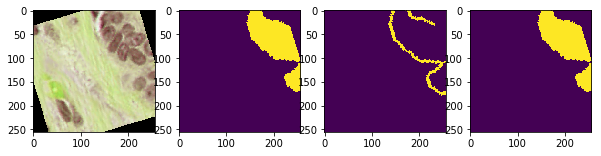

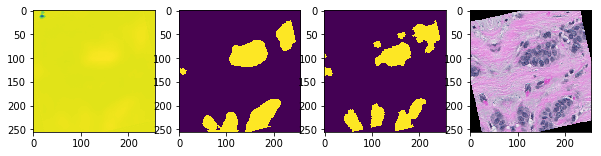

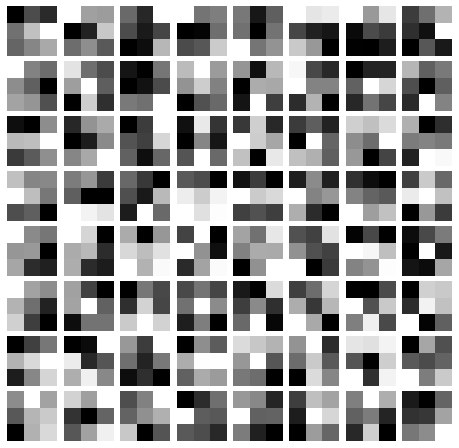

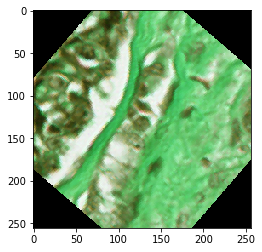

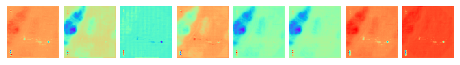

fin


In [12]:
%matplotlib inline
#visualize a single example to verify that it is correct
print("Training example image and mask")
(img,patch_mask,patch_mask_weight)=dataset["train"][14]
fig, ax = plt.subplots(1,4, figsize=(10,4))  # 1 row, 2 columns

#build output showing original patch  (after augmentation), class = 1 mask, weighting mask, overall mask (to see any ignored classes)
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(patch_mask==1)
ax[2].imshow(patch_mask_weight)
ax[3].imshow(patch_mask)
################################################################################
#helper function for visualization
################################################################################

########################################
def plot_kernels(tensor, num_cols=8 ,cmap="gray"):
    if not len(tensor.shape)==4:
        raise Exception("assumes a 4D tensor")
#    if not tensor.shape[1]==3:
#        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0] * tensor.shape[1]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    i=0
    t=tensor.data.numpy()
    for t1 in t:
        for t2 in t1:
            i+=1
            ax1 = fig.add_subplot(num_rows,num_cols,i)
            ax1.imshow(t2 , cmap=cmap)
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


########################################
class LayerActivations():
    features=None
    def __init__(self,layer):
        self.hook = layer.register_forward_hook(self.hook_fn)
    def hook_fn(self,module,input,output):
        self.features = output.cpu()
    def remove(self):
        self.hook.remove()

################################################################################
# Post-Training Reports
################################################################################

# Load the best model
checkpoint = torch.load(dataname+"_unet_best_model_1.pth")
UNetRuntime.load_state_dict(checkpoint["model_dict"])

# Grab a single image from validation set
[img,mask,mask_weight] = dataset["train"][14]

# generate its output
output=UNetRuntime(img[None,::].to(torchDevice))
output=output.detach().squeeze().cpu().numpy()
output=np.moveaxis(output,0,-1) 
output.shape

#visualize its result
print("Example output and mask generated")
fig, ax = plt.subplots(1,4, figsize=(10,4))  # 1 row, 2 columns
ax[0].imshow(output[:,:,1])
ax[1].imshow(np.argmax(output,axis=2))
ax[2].imshow(mask) #actual mask?
ax[3].imshow(np.moveaxis(img.numpy(),0,-1)) #input image

w = UNetRuntime.up_path[2].conv_block.block[3]
plot_kernels(w.weight.detach().cpu(),8)
dr = LayerActivations(UNetRuntime.up_path[2].conv_block.block[3])

[img, mask, mask_weight] = dataset["val"][7]
plt.imshow(np.moveaxis(img.numpy(),0,-1))
output = UNetRuntime(img[None,::].to(torchDevice))
plot_kernels(dr.features,8,cmap="rainbow")
print("fin")